In [33]:
import pandas as pd
import seaborn as sns
from pyts.classification import TimeSeriesForest
import matplotlib.pyplot as plt
import numpy as np
from tsai.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, roc_auc_score, f1_score, accuracy_score, classification_report
import sklearn.metrics as skm
from sklearn.preprocessing import StandardScaler
from utils import *

## Utility functions

In [34]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted: No', 'Predicted: Yes'], 
                yticklabels=['Actual: No', 'Actual: Yes'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

## Read data and choose person index

In [35]:
error_signal = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/e.csv', delimiter=',')
u_signal =np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/u.csv', delimiter=',')
tc = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/mdist.csv', delimiter=',')

run_index = 0

# use three runs for training and one for testing
error_signal = error_signal[:, run_index:run_index+4].flatten()
u_signal = u_signal[:, run_index:run_index+4].flatten()
tc = tc[:, run_index:run_index+4].flatten()

# flatten the data


print(f"mean: {np.mean(error_signal)}; var: {np.std(error_signal)}")

mean: 0.006782156976681873; var: 0.16129064433969031


In [36]:
# Create feature matrix and labels
scaler = StandardScaler()
error_signal = scaler.fit_transform(error_signal.reshape(-1, 1)).flatten()
u_signal = scaler.fit_transform(u_signal.reshape(-1, 1)).flatten()

error_derivative = np.diff(error_signal)
u_signal_derivative = np.diff(u_signal)

error_derivative = scaler.fit_transform(error_derivative.reshape(-1, 1)).flatten()
u_signal_derivative = scaler.fit_transform(u_signal_derivative.reshape(-1, 1)).flatten()

X = np.column_stack((error_signal[:-1], u_signal[:-1], error_derivative, u_signal_derivative))

y = tc

In [37]:
# Convert to DataFrame
df = pd.DataFrame(X, columns=['error_signal', 'u_signal', 'error_signal_derivative', 'u_signal_derivative'])

df['label'] = y[:-1]

       error_signal
count  47999.000000
mean       0.000016
std        1.000015
min       -7.587434
25%       -0.408258
50%        0.047975
75%        0.467624
max        9.158732


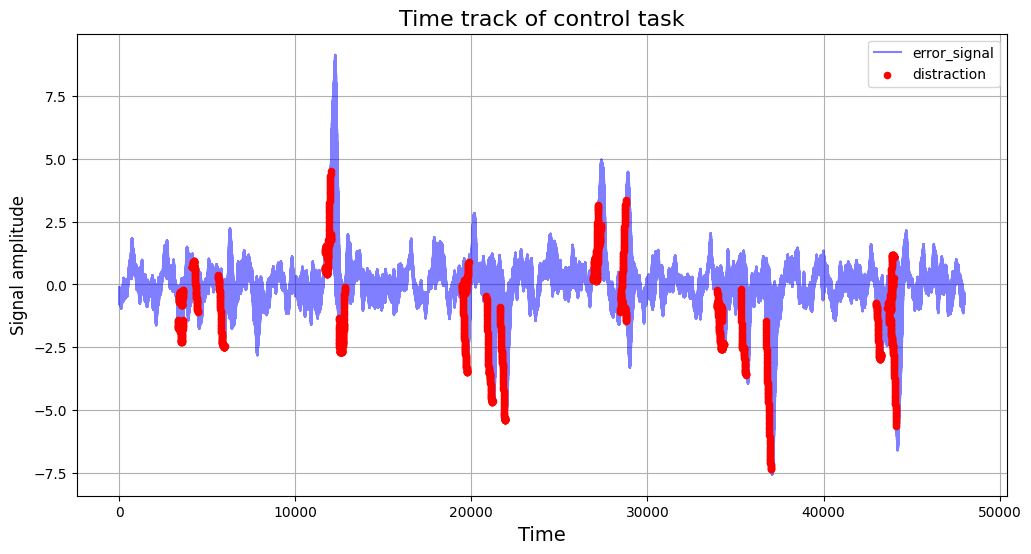

In [38]:
def plot_neutral(df):
    """
    Function: Shows summary statistics, plots neutral current
    Input: Dataframe
    Output: Plot
    """

    plt.figure(figsize=(12, 6))
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Signal amplitude', fontsize=12)
    
    print(df[['error_signal']].describe())
    
    # Define colors for the labeled and unlabeled data points
    label_color = 'red'
    other_color = 'blue'
    
    # Plot all data points with the default color
    plt.plot(df['error_signal'], label='error_signal', color=other_color, alpha=0.5)
    
    # Highlight data points corresponding to the label with smaller scatter points
    plt.scatter(df.index[df['label'] == 1], df['error_signal'][df['label'] == 1], 
                color=label_color, label='distraction', s=20, zorder=5)
    plt.grid()
    plt.title('Time track of control task', fontsize=16)
    plt.legend() 
    plt.show()


plot_neutral(df)

## Choose features

In [39]:
features = ['error_signal', 'u_signal', 'error_signal_derivative', 'u_signal_derivative']

anomaly_value_binary
0.0    46256
1.0     1743
Name: count, dtype: int64


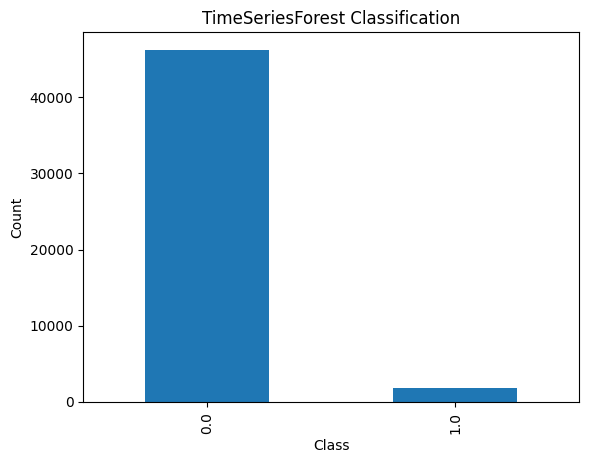


Test Accuracy: 0.9699166666666666

Classification Report:
                 precision    recall  f1-score   support

Not Distracted       0.98      0.99      0.98     11617
    Distracted       0.55      0.32      0.41       383

      accuracy                           0.97     12000
     macro avg       0.76      0.66      0.70     12000
  weighted avg       0.96      0.97      0.97     12000



In [40]:
# Initialize the TimeSeriesForest classifier
clf = TimeSeriesForest(n_estimators=500, random_state=42)
# Prepare the data
X = df[features].values
y = df['label'].values  # Assuming you have a 'label' column with 0 and 1

# Split the data into training and testing sets
# Split the data into training and testing sets
train_size = int(len(df) * 0.75)  # Use 70% for training, 30% for testing
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Fit the model on the training data
clf.fit(X_train, y_train)

# Predict the labels for the test set
df['anomaly_value_binary'] = clf.predict(X)

# Optionally, calculate the probability scores (not directly available in TimeSeriesForest)
# You can use clf.predict_proba(X) to get the probabilities for each class

# Analyze the results
outliers = df.loc[df['anomaly_value_binary'] == 1]
outlier_index = list(outliers.index)

# Print the count of normal vs. anomalous samples
print(df['anomaly_value_binary'].value_counts())

# Plot the results
df['anomaly_value_binary'].value_counts().plot(kind='bar')
plt.title('TimeSeriesForest Classification')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# If you want to evaluate the performance on a test set:
y_pred = clf.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Not Distracted', 'Distracted']))

AUC: 0.87


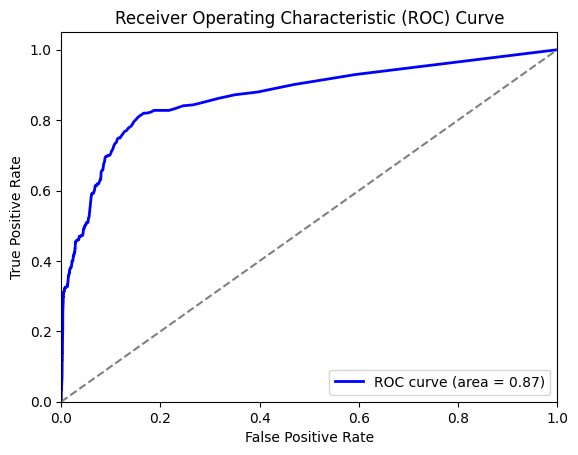

In [41]:
# Predict the probability estimates for the test set
y_proba = clf.predict_proba(X_test)[:, 1]  # Probability of the positive class (anomalous)

# Compute the AUC
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc_score:.2f}")

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

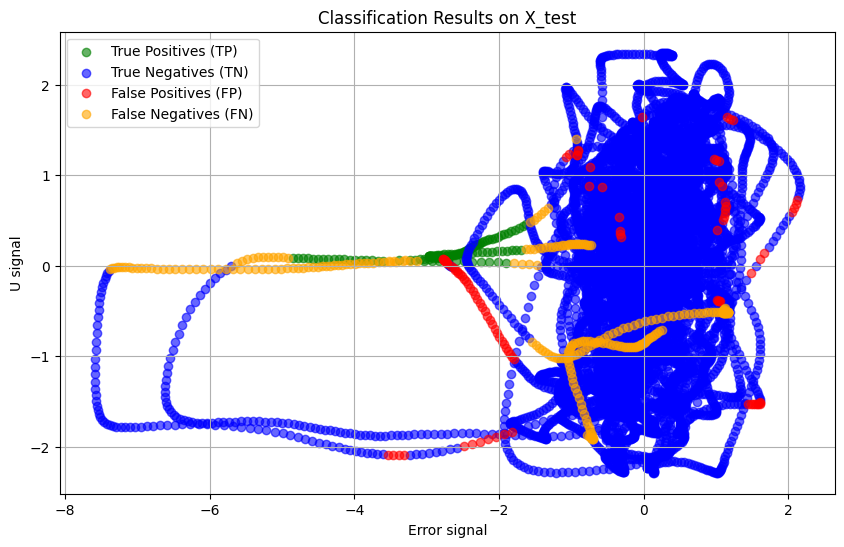

In [42]:
# Define masks for the four cases
TP_mask = (y_pred == 1) & (y_test == 1)
TN_mask = (y_pred == 0) & (y_test == 0)
FP_mask = (y_pred == 1) & (y_test == 0)
FN_mask = (y_pred == 0) & (y_test == 1)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot True Positives
plt.scatter(X_test[TP_mask, 0], X_test[TP_mask, 1], color='green', label='True Positives (TP)', alpha=0.6)

# Plot True Negatives
plt.scatter(X_test[TN_mask, 0], X_test[TN_mask, 1], color='blue', label='True Negatives (TN)', alpha=0.6)

# Plot False Positives
plt.scatter(X_test[FP_mask, 0], X_test[FP_mask, 1], color='red', label='False Positives (FP)', alpha=0.6)

# Plot False Negatives
plt.scatter(X_test[FN_mask, 0], X_test[FN_mask, 1], color='orange', label='False Negatives (FN)', alpha=0.6)

# Add labels and title
plt.xlabel('Error signal')
plt.ylabel('U signal')
plt.title('Classification Results on X_test')
plt.legend()
plt.grid()
plt.show()

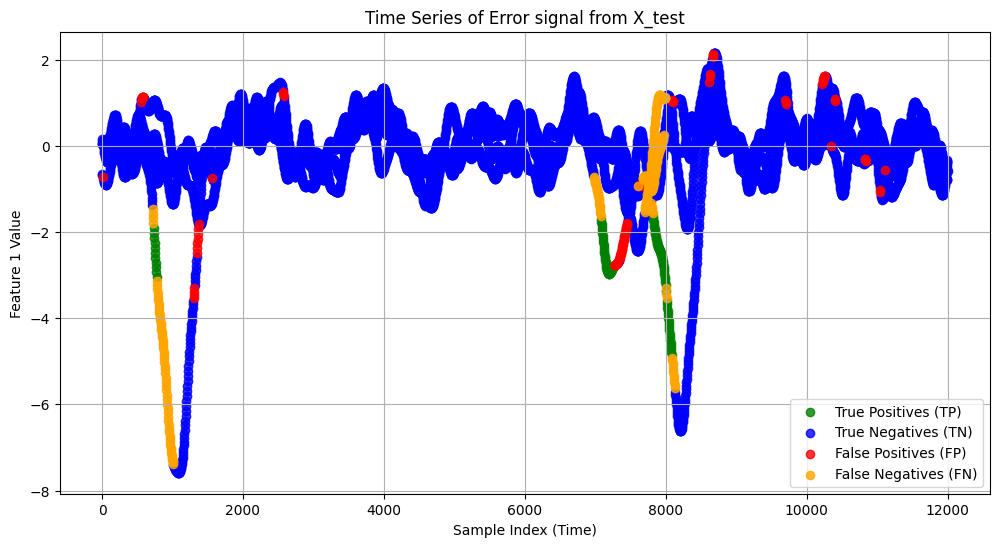

In [43]:
# Create the time series plot
plt.figure(figsize=(12, 6))

# Time axis (assuming sample indices represent time)
time_axis = np.arange(len(X_test))

# Scatter plot for True Positives
plt.scatter(time_axis[TP_mask], X_test[TP_mask, 0], color='green', label='True Positives (TP)', alpha=0.8, marker='o')

# Scatter plot for True Negatives
plt.scatter(time_axis[TN_mask], X_test[TN_mask, 0], color='blue', label='True Negatives (TN)', alpha=0.8, marker='o')

# Scatter plot for False Positives
plt.scatter(time_axis[FP_mask], X_test[FP_mask, 0], color='red', label='False Positives (FP)', alpha=0.8, marker='o')

# Scatter plot for False Negatives
plt.scatter(time_axis[FN_mask], X_test[FN_mask, 0], color='orange', label='False Negatives (FN)', alpha=0.8, marker='o')

# Add labels and title
plt.xlabel('Sample Index (Time)')
plt.ylabel('Feature 1 Value')
plt.title('Time Series of Error signal from X_test')
plt.legend()
plt.grid()
plt.show()

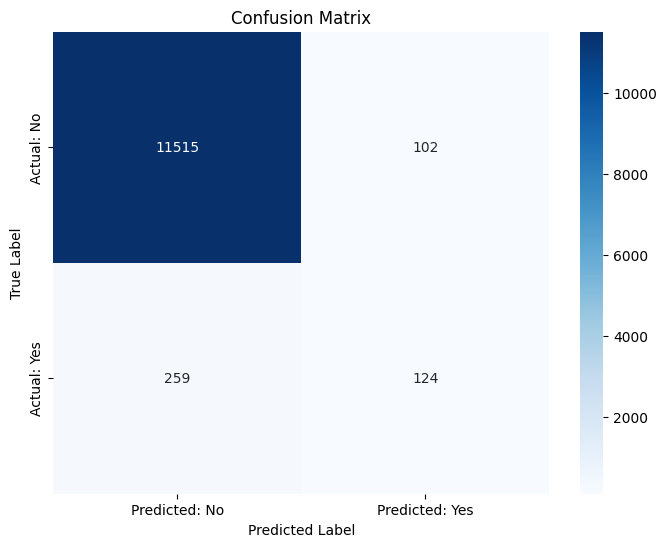

In [44]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

anomaly_value_binary
0.0    46256
1.0     1743
Name: count, dtype: int64


<Axes: xlabel='anomaly_value_binary'>

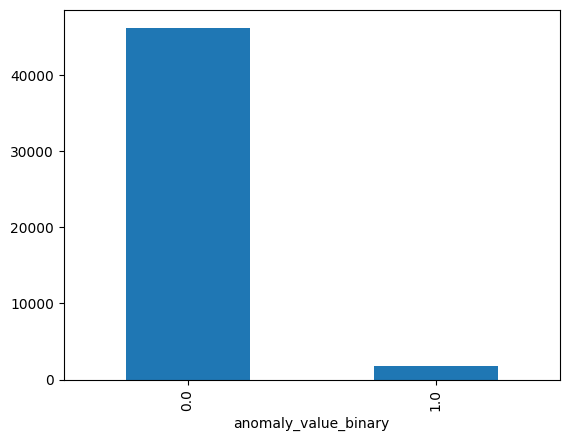

In [45]:
outliers = df.loc[df['anomaly_value_binary'] == 1]
outlier_index = list(outliers.index)

#datapoints classified -1 are anomalous
print(df['anomaly_value_binary'].value_counts())
df['anomaly_value_binary'].value_counts().plot(kind = 'bar')

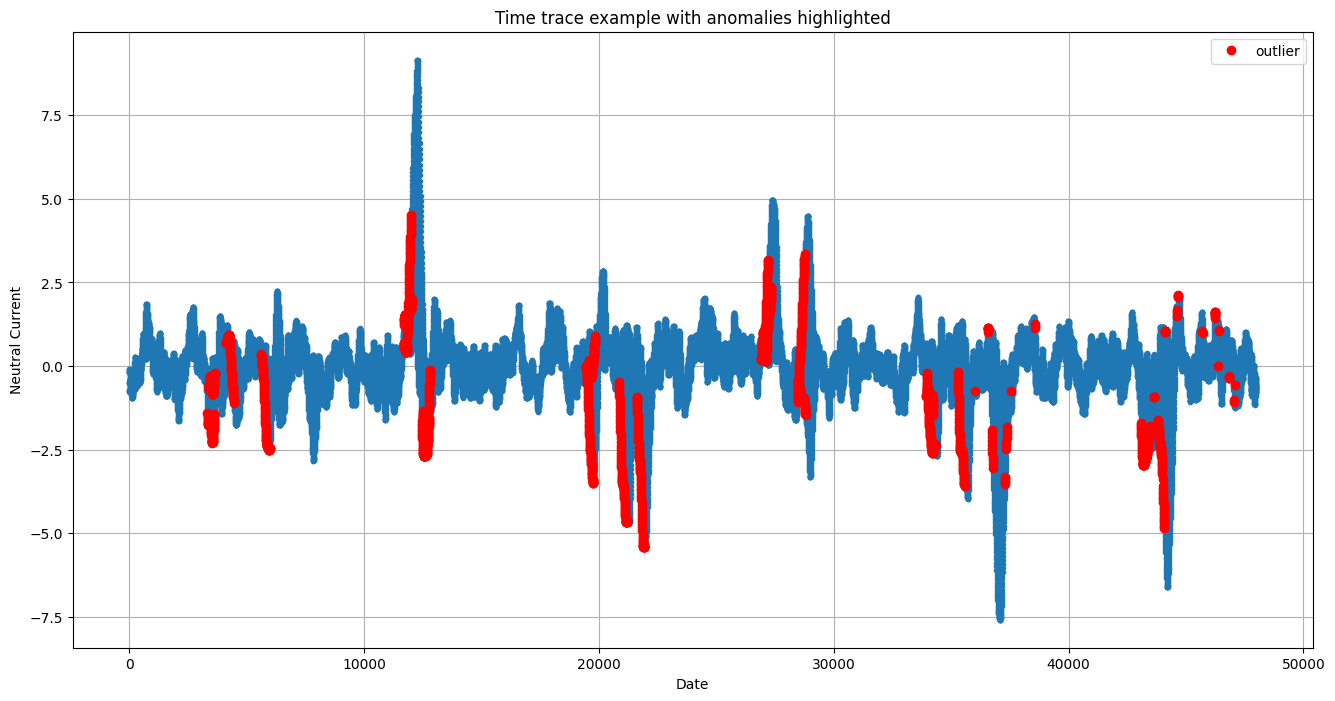

In [46]:
plt.figure(figsize = (16, 8))

plt.plot(df['error_signal'], marker = '.')
plt.plot(outliers['error_signal'], 'o', color = 'red', label = 'outlier')
plt.title('Time trace example with anomalies highlighted')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Neutral Current')
plt.legend()

In [47]:
# Calculate metrics
y_true = df['label']
y_pred = df['anomaly_value_binary']

# Compute AUC
auc_score = roc_auc_score(y_true, y_pred)
print(f"AUC: {auc_score:.2f}")

# Compute F1 Score
f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1:.2f}")

# Compute Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print a detailed classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

AUC: 0.93
F1 Score: 0.90
Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     46099
         1.0       0.94      0.86      0.90      1900

    accuracy                           0.99     47999
   macro avg       0.97      0.93      0.95     47999
weighted avg       0.99      0.99      0.99     47999



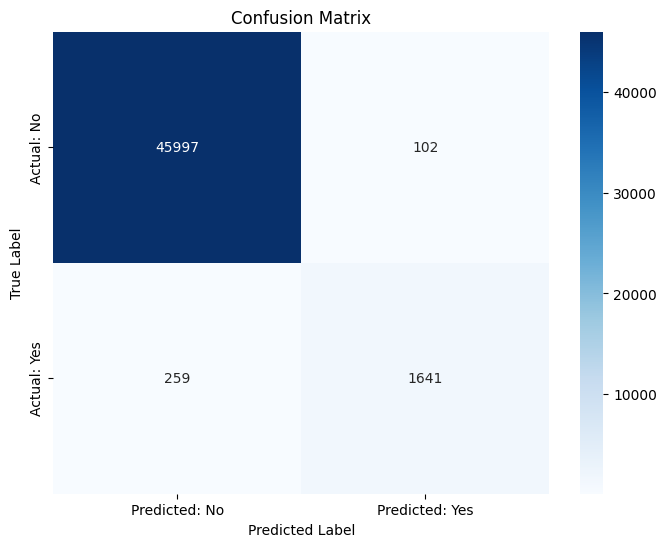

In [48]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(conf_matrix)

In [49]:
print('Done!')

Done!


## Use windowed data

In [50]:
def create_windowed_data(df, features, labels, window_size, overlap, anomaly_threshold=10):
    """
    Creates windowed data with overlap.
    
    Parameters:
    - df: The original DataFrame.
    - features: List of columns to use as features.
    - window_size: The size of each window.
    - overlap: The number of overlapping points between consecutive windows.
    
    Returns:
    - windowed_data: A 2D array where each row is a flattened window.
    """
    step_size = window_size - overlap
    windows = []
    window_labels = []
    
    for start in range(0, len(df) - window_size + 1, step_size):
        window = df[features].iloc[start:start + window_size].values.flatten()
        windows.append(window)
        
        # Aggregate labels: If any point in the window is an anomaly, label the entire window as an anomaly
        anomaly_count = np.sum(labels[start:start + window_size] == 1)
        
        if anomaly_count > anomaly_threshold:
            window_labels.append(1)
        else:
            window_labels.append(0)
    
    return np.array(windows), np.array(window_labels)


# Example usage:
window_size = 10
overlap = 5
anomaly_threshold = 5

windowed_data, windowed_labels = create_windowed_data(df, features, df['label'].values, window_size, overlap, anomaly_threshold)

print(windowed_data.shape)

(9598, 40)


AUC: 0.9988983619120606


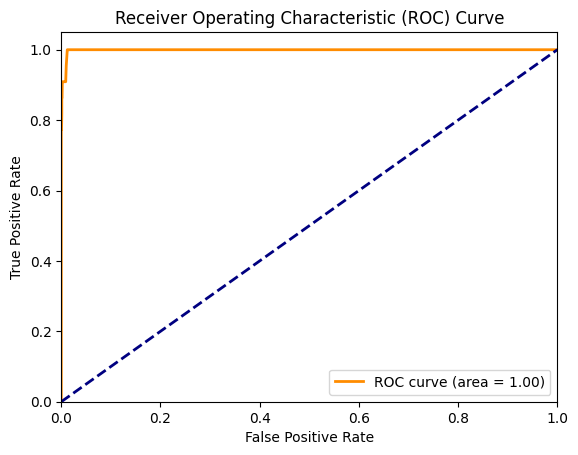

Accuracy: 0.9953125
F1 Score: 0.7428571428571429
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1898
           1       1.00      0.59      0.74        22

    accuracy                           1.00      1920
   macro avg       1.00      0.80      0.87      1920
weighted avg       1.00      1.00      0.99      1920



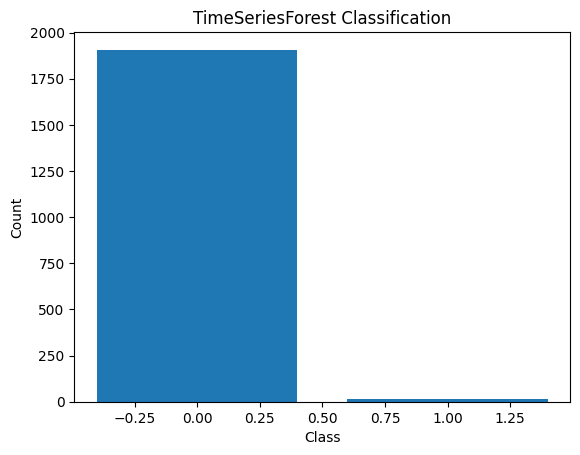


Test Accuracy: 0.9953125

Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      1898
     Class 1       1.00      0.59      0.74        22

    accuracy                           1.00      1920
   macro avg       1.00      0.80      0.87      1920
weighted avg       1.00      1.00      0.99      1920



In [51]:
# Initialize the classifier
clf2 = TimeSeriesForest(n_estimators=100, random_state=42)

# Prepare the data
X = windowed_data
y = windowed_labels  # Assuming you have a 'label' column with 0 and 1

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model on the training data
clf2.fit(X_train, y_train)

# Predict the labels for the test set
anomaly_score_binary = clf2.predict(X_test)


# Evaluate the model on the test set
accuracy = accuracy_score(y_test, anomaly_score_binary)
f1 = f1_score(y_test, anomaly_score_binary)
report = classification_report(y_test, anomaly_score_binary)

# If `predict_proba` is available and desired
if hasattr(clf2, "predict_proba"):
    anomaly_scores2 = clf2.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, anomaly_scores2)

    print(f'AUC: {auc_score}')

# Check if the model has the predict_proba method
if hasattr(clf2, "predict_proba"):
    # Get the probability scores for the positive class (class 1)
    anomaly_scores2 = clf2.predict_proba(X_test)[:, 1]
    
    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, anomaly_scores2)
    
    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print("Classification Report:")
print(report)

# Optionally, plot the binary anomaly predictions
plt.bar(*np.unique(anomaly_score_binary, return_counts=True))
plt.title('TimeSeriesForest Classification')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# If you want to evaluate the performance on a test set:
y_pred = clf2.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

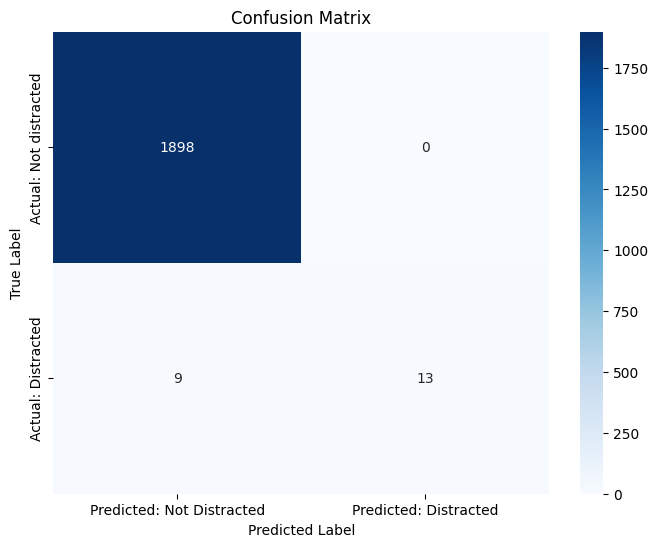

In [52]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted: Not Distracted', 'Predicted: Distracted'], 
            yticklabels=['Actual: Not distracted', 'Actual: Distracted'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

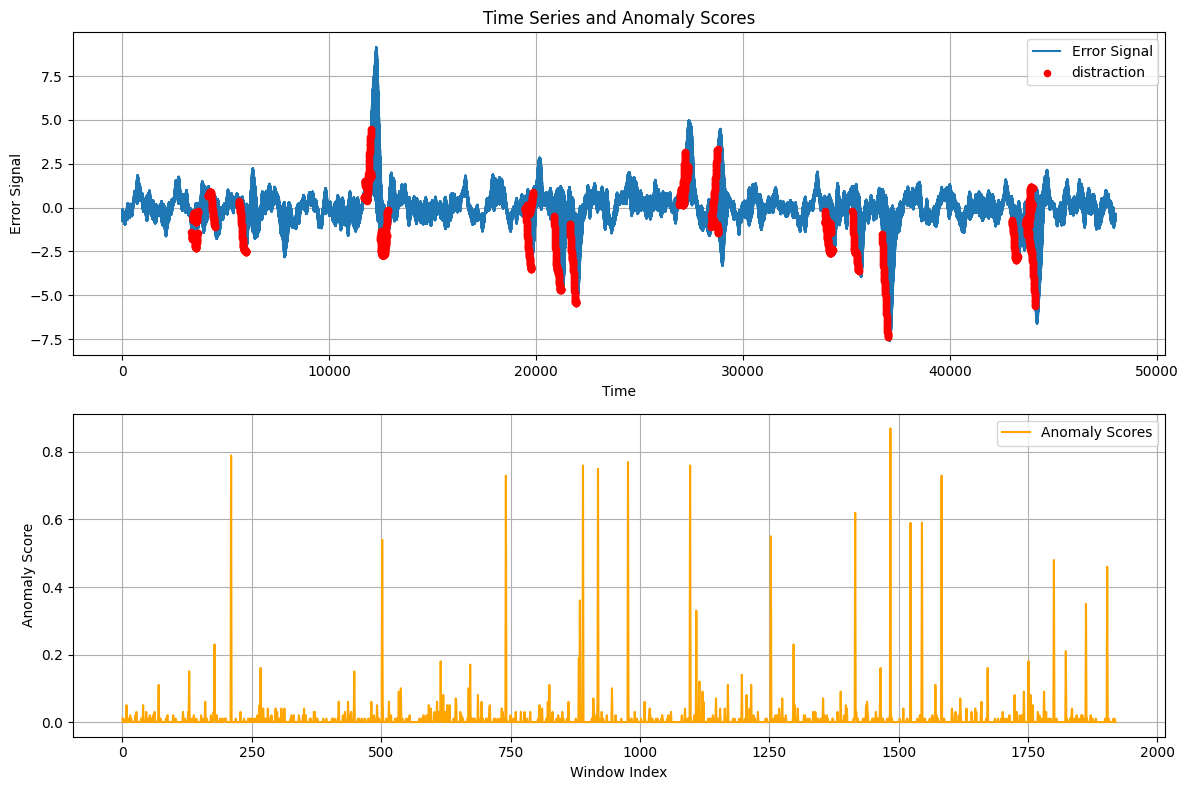

In [53]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(df['error_signal'], label='Error Signal')
plt.scatter(df.index[df['label'] == 1], df['error_signal'][df['label'] == 1], 
                color='red', label='distraction', s=20, zorder=5)
plt.grid()
plt.xlabel('Time')
plt.ylabel('Error Signal')
plt.title('Time Series and Anomaly Scores')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(anomaly_scores2, label='Anomaly Scores', color='orange')
plt.grid()
plt.xlabel('Window Index')
plt.ylabel('Anomaly Score')
plt.legend()

plt.tight_layout()
plt.show()

## Visualisation

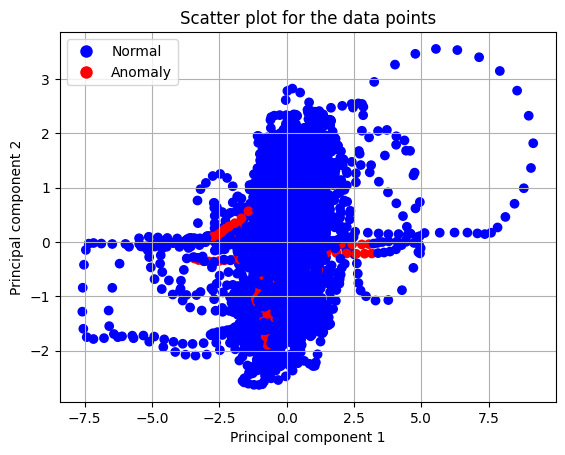

In [54]:
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(df)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']
cdict = {0: 'blue', 1: 'red'}
plt.scatter(X[:, 0], X[:, 1], c=[cdict[label] for label in y], alpha=1)
plt.title('Scatter plot for the data points')
plt.xlabel('Principal component 1') 
plt.grid()
plt.ylabel('Principal component 2') 
labels = ['Normal', 'Anomaly'] 
colors = [cdict[0], cdict[1]]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]

plt.legend(handles, labels, loc='best')